In [1]:
import os
import pickle

import community as community_louvain
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

from constants import AGGR_GRAPH_PATH, COMMUNITY_PARTITIONS_FPATH

In [4]:
G = nx.read_graphml(AGGR_GRAPH_PATH)
print("Graph loaded successfully.")
UG = nx.Graph(G)
print("Nodes:", UG.number_of_nodes())
print("Edges:", UG.number_of_edges())

Graph loaded successfully.
Nodes: 145652
Edges: 199277


In [5]:
pos = {}
for n, data in UG.nodes(data=True):
    try:
        x = float(data.get("x"))
        y = float(data.get("y"))
        pos[n] = (x, y)
    except (TypeError, ValueError):
        pos[n] = None

pos = {n: p for n, p in pos.items() if p is not None}

print("Nodes with coordinates:", len(pos))

# Connected components
cc = list(nx.connected_components(UG))
print("Connected components:", len(cc))
largest_cc = max(cc, key=len)
smallest_cc = min(cc, key=len)
print("Largest CC size:", len(largest_cc))
print("Smallest CC size:", len(smallest_cc))

Nodes with coordinates: 145652
Connected components: 3
Largest CC size: 145131
Smallest CC size: 226


## Louvain + One-Hot Encoding Community Labels

In [7]:
if not os.path.exists(COMMUNITY_PARTITIONS_FPATH):
    print("Computing communities.")
    partition = community_louvain.best_partition(UG, resolution=2.0)
    with open(COMMUNITY_PARTITIONS_FPATH, "wb") as f:
        pickle.dump(partition, f)
else:
    print("Community partitions found. Loading.")
    with open(COMMUNITY_PARTITIONS_FPATH, "rb") as f:
        partition = pickle.load(f)

Community partitions found. Loading.


In [8]:
comm_ids = sorted(set(partition.values()))
col_names = {cid: f"comm_{i}" for i, cid in enumerate(comm_ids)}

attrs = {}
for n in UG.nodes():
    node_comm = partition.get(n)
    # create one-hot dict with all zeros then set the community column to 1
    d = {name: 0 for name in col_names.values()}
    if node_comm is not None:
        d[col_names[node_comm]] = 1
    attrs[n] = d

nx.set_node_attributes(UG, attrs)

num_comms = len(set(partition.values()))
print(f"Detected communities: {num_comms}")

Detected communities: 280


In [9]:
first_5 = list(UG.nodes())[:5]
rows = []
for n in first_5:
    data = UG.nodes[n]
    row = {"node": n}
    row.update(data)
    rows.append(row)
df = pd.DataFrame(rows)

df

,node,y,x,street_count,population,distance_to_nearest_stop,comm_0,comm_1,comm_2,comm_3,...,comm_270,comm_271,comm_272,comm_273,comm_274,comm_275,comm_276,comm_277,comm_278,comm_279
0,59634015,3483055.31840465,431533.1463635152,3,132.10456468648016,1935.644160680242,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8146995886,3483172.5696452633,431801.55298390007,3,135.51563730638114,2139.549176882604,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8146995882,3483110.3897345774,431672.5659113366,3,135.51563730638114,2041.6263475206397,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,59634249,3483474.1187934345,432374.20390228514,3,115.52274860081941,2601.3111029410416,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,59635978,3483586.6976678683,432550.8594353466,3,115.52274860081941,2725.1025481723473,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


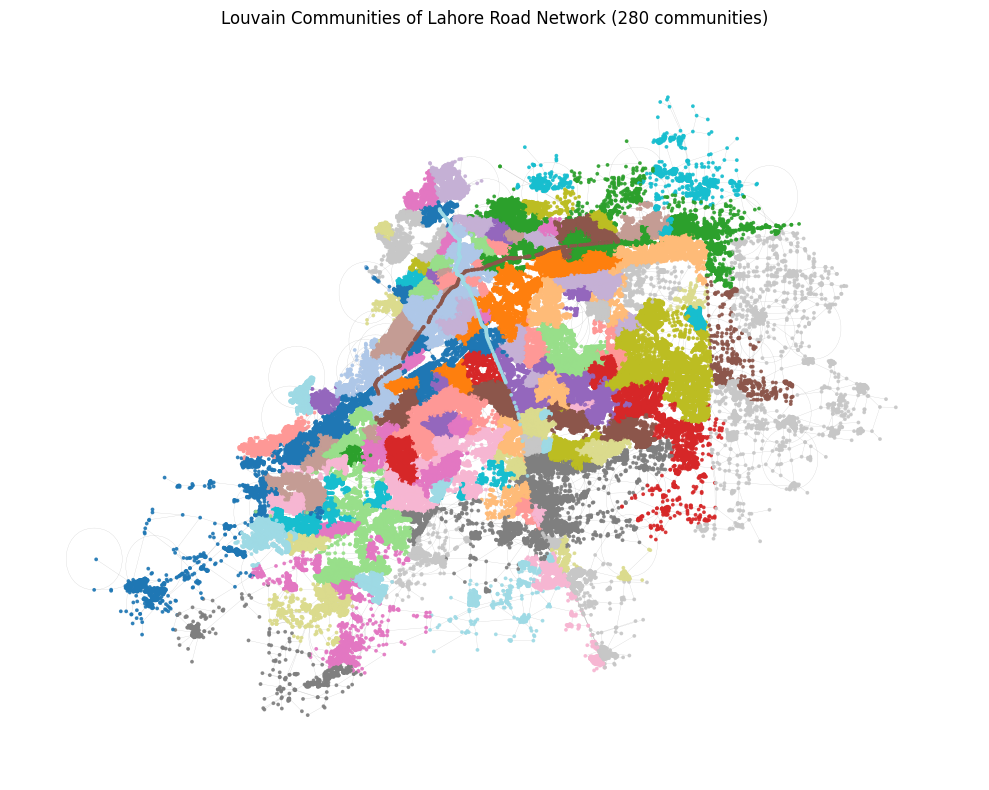

In [10]:
unique_coms = sorted(set(partition.values()))
color_map = {c: i for i, c in enumerate(unique_coms)}
node_colors = [color_map[partition[n]] for n in UG.nodes()]

plt.figure(figsize=(10, 8))
plt.title(
    f"Louvain Communities of Lahore Road Network ({num_comms} communities)", fontsize=12
)

nx.draw_networkx_nodes(
    UG,
    pos=pos,
    node_size=3,
    node_color=node_colors,
    cmap=plt.cm.tab20,  # type: ignore
    alpha=0.85,
)

nx.draw_networkx_edges(UG, pos=pos, width=0.2, edge_color="gray", alpha=0.4)

plt.axis("off")
plt.tight_layout()
plt.show()